In [8]:
import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout
from keras.initializers import Constant

In [9]:
df = pd.read_csv('../data/output/3_labeling_1.csv')

In [10]:
df.head()

,Date,Text,Normalized_Text_NLTK,Normalized_Text_Slang,Sentiment
0,07/2023,Fore dihati,fore dihati,fore dihati,positive
1,07/2023,"Biasa pesen latte no sugar, menu terenak di fo...",biasa pesen latte no sugar menu terenak di for...,biasa pesen latte no gula menu terenak di fore...,positive
2,07/2023,Aku tim point coffee,aku tim point coffee,aku tim point coffee,neutral
3,07/2023,"Masih banyak sih, tapi rata-rata fore",masih banyak sih tapi ratarata fore,masih banyak sih tapi ratarata fore,neutral
4,07/2023,yg terakhir dalgona berkedok fore,yg terakhir dalgona berkedok fore,yang terakhir dalgona berkedok fore,neutral


In [11]:
# TEXT CLEANING + TOKENIZATION
# ===========================
def read_file_as_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return dict(line.strip().split(':', 1) for line in f if ':' in line)

root_dict = read_file_as_dict('../src/NLP_bahasa_resources/combined_root_words.txt')
slang_dict = read_file_as_dict('../src/NLP_bahasa_resources/combined_slang_words.txt')
stopwords_dict = set(open('../src/NLP_bahasa_resources/combined_stop_words.txt', 'r', encoding='utf-8').read().splitlines())
factory = StopWordRemoverFactory()
indonesian_stopwords = set(factory.get_stop_words())

def normalize_text(text, slang_dict, root_dict, stopwords_dict):
    tokens = word_tokenize(text.lower())
    normalized = []

    for token in tokens:
        # Convert slang
        if token in slang_dict:
            token = slang_dict[token]

        # Convert to root/base form
        if token in root_dict:
            token = root_dict[token]

        # Remove stopwords
        if token in stopwords_dict:
            continue

        normalized.append(token)

    return normalized


def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in indonesian_stopwords]
    return tokens

def preprocess_dataframe(df, text_col='Normalized_Text_Slang'):
    df['tokens'] = df['Normalized_Text_Slang'].apply(lambda x: normalize_text(x, slang_dict, root_dict, stopwords_dict))
    return df


df = preprocess_dataframe(df)


In [12]:
df

,Date,Text,Normalized_Text_NLTK,Normalized_Text_Slang,Sentiment,tokens
0,07/2023,Fore dihati,fore dihati,fore dihati,positive,"[fore, dihati]"
1,07/2023,"Biasa pesen latte no sugar, menu terenak di fo...",biasa pesen latte no sugar menu terenak di for...,biasa pesen latte no gula menu terenak di fore...,positive,"[pesen, latte, gula, menu, terenak, fore, menu..."
2,07/2023,Aku tim point coffee,aku tim point coffee,aku tim point coffee,neutral,"[tim, point, coffee]"
3,07/2023,"Masih banyak sih, tapi rata-rata fore",masih banyak sih tapi ratarata fore,masih banyak sih tapi ratarata fore,neutral,"[sih, ratarata, fore]"
4,07/2023,yg terakhir dalgona berkedok fore,yg terakhir dalgona berkedok fore,yang terakhir dalgona berkedok fore,neutral,"[dalgona, berkedok, fore]"
...,...,...,...,...,...,...
2565,06/2024,Yg kopi kenangan juga enak cromboloniya,yg kopi kenangan juga enak cromboloniya,yang kopi kenangan juga enak cromboloniya,positive,"[kopi, kenangan, enak, cromboloniya]"
2566,06/2024,Ini di semua kopi kenangan?,ini di semua kopi kenangan,ini di semua kopi kenangan,positive,"[kopi, kenangan]"
2567,06/2024,- feel matcha - lawson - point coffee dari aku...,feel matcha lawson point coffee dari aku si...,feel matcha lawson point coffee dari aku si pe...,negative,"[feel, matcha, lawson, point, coffee, si, peci..."
2568,06/2024,- tomoro (plz enak bgt) - fore (kl suka creamy...,tomoro plz enak bgt fore kl suka creamy must...,tomoro plz enak banget fore kalau suka creamy ...,positive,"[tomoro, plz, enak, banget, fore, suka, creamy..."


In [13]:
# TOKENIZER + PADDING
# ===========================
texts = df['tokens'].apply(lambda tokens: ' '.join(tokens)).tolist()
max_len = 50
num_words = 10000

tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')


In [14]:
# GLOVE EMBEDDING LOADER
# ===========================
def load_glove_embeddings(glove_path, word_index, embedding_dim=100):
    embeddings_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

# Provide your actual GloVe file path
glove_path = '../src/glove/glove.6B.100d.txt'
embedding_matrix = load_glove_embeddings(glove_path, tokenizer.word_index, 100)


In [15]:
# CNN + BiLSTM MODEL
# ===========================
def build_cnn_bilstm_model(vocab_size, embedding_matrix, max_len, embedding_dim=100, num_classes=3):
    input_ = Input(shape=(max_len,))
    
    x = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )(input_)

    x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_, outputs=output)
    return model

model = build_cnn_bilstm_model(
    vocab_size=len(tokenizer.word_index)+1,
    embedding_matrix=embedding_matrix,
    max_len=max_len,
    embedding_dim=100,
    num_classes=3  # Positive, Negative, Neutral
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



📦 Fold 1 Starting...
Epoch 1/20


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.4657 - loss: 1.0937 - val_accuracy: 0.4981 - val_loss: 0.9465
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4833 - loss: 1.0016 - val_accuracy: 0.4514 - val_loss: 0.9893
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5512 - loss: 0.8938 - val_accuracy: 0.4163 - val_loss: 1.1040
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6135 - loss: 0.7853 - val_accuracy: 0.4669 - val_loss: 1.0467
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
✅ Fold 1 Accuracy: 0.4981
🧮 Fold 1 Log Loss: 0.9465

📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.50      0.04      0.07        57
     neutral       0.18      0.61      0.27        33
    positive       0.76      0.63      0.69       167

    accuracy                           0.50       257
   macro avg       0.48      0.43      0.34       257
weighted avg       0.63      0.50      0.50       257



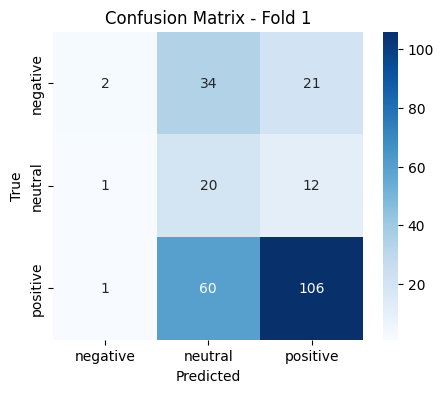


📦 Fold 2 Starting...
Epoch 1/20


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.4239 - loss: 1.0794 - val_accuracy: 0.4864 - val_loss: 0.9838
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5081 - loss: 0.9914 - val_accuracy: 0.5564 - val_loss: 0.8931
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5612 - loss: 0.8676 - val_accuracy: 0.5409 - val_loss: 0.9063
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6039 - loss: 0.8082 - val_accuracy: 0.5370 - val_loss: 0.9806
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6541 - loss: 0.6877 - val_accuracy: 0.5525 - val_loss: 0.9466
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
✅ Fold 2 Accuracy: 0.5564
🧮 Fold 2 Log Loss: 0.8931

📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.35      0.54      0.42        57
     neutral       0.24      0.36      0.29        33
    positive       0.84      0.60      0.70       167

    accuracy                           0.5

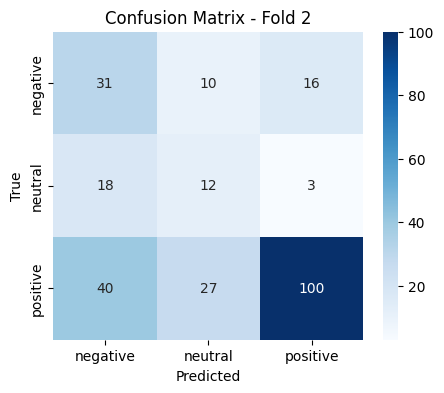


📦 Fold 3 Starting...
Epoch 1/20


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5247 - loss: 1.0606 - val_accuracy: 0.3891 - val_loss: 1.0578
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4979 - loss: 0.9842 - val_accuracy: 0.3735 - val_loss: 1.1008
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5248 - loss: 0.9416 - val_accuracy: 0.5759 - val_loss: 0.8512
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6016 - loss: 0.8374 - val_accuracy: 0.4942 - val_loss: 1.0277
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6513 - loss: 0.6967 - val_accuracy: 0.5837 - val_loss: 0.9301
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6829 - loss: 0.6419 - val_accuracy: 0.5642 - val_loss: 0.9071
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
✅ Fold 3 Accuracy: 0.5759
🧮 Fold 3 Log Loss: 0.8512

📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.35      0.49      0.41        57
     neutral       0.32 

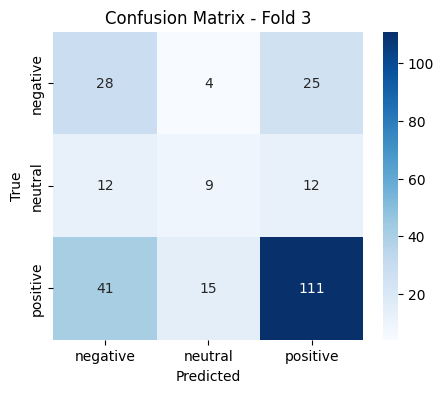


📦 Fold 4 Starting...
Epoch 1/20


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.3697 - loss: 1.0940 - val_accuracy: 0.2996 - val_loss: 1.1328
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4670 - loss: 0.9839 - val_accuracy: 0.5058 - val_loss: 0.9393
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5242 - loss: 0.9289 - val_accuracy: 0.4747 - val_loss: 1.0402
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5731 - loss: 0.8244 - val_accuracy: 0.4514 - val_loss: 1.0828
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6343 - loss: 0.7232 - val_accuracy: 0.5253 - val_loss: 1.0427
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
✅ Fold 4 Accuracy: 0.5058
🧮 Fold 4 Log Loss: 0.9393

📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.35      0.21      0.26        57
     neutral       0.16      0.42      0.23        33
    positive       0.77      0.62      0.69       167

    accuracy                           0.5

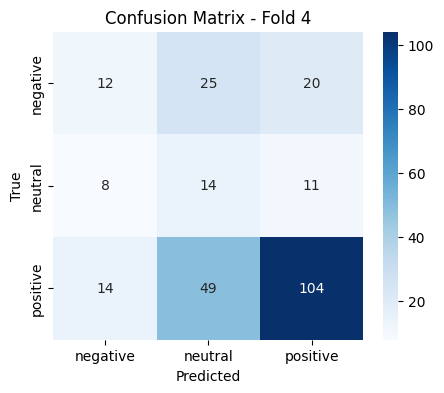


📦 Fold 5 Starting...


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4157 - loss: 1.0796 - val_accuracy: 0.3307 - val_loss: 1.1272
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4983 - loss: 0.9899 - val_accuracy: 0.3891 - val_loss: 1.1029
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5246 - loss: 0.9036 - val_accuracy: 0.4903 - val_loss: 0.9526
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5994 - loss: 0.8535 - val_accuracy: 0.3774 - val_loss: 1.2076
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5958 - loss: 0.7848 - val_accuracy: 0.4514 - val_loss: 1.0826
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6998 - loss: 0.6192 - val_accuracy: 0.5331 - val_loss: 1.0248
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
✅ Fold 5 Accuracy: 0.4903
🧮 Fold 5 Log Loss: 0.9526

📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.33      0.39      0.36        57
     neutral 

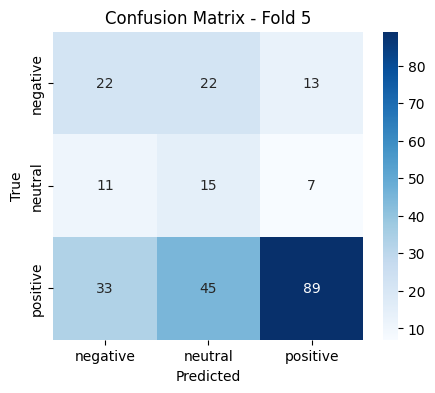


📦 Fold 6 Starting...
Epoch 1/20


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.4194 - loss: 1.0809 - val_accuracy: 0.5525 - val_loss: 0.9429
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4826 - loss: 0.9792 - val_accuracy: 0.5720 - val_loss: 0.9046
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5384 - loss: 0.9252 - val_accuracy: 0.5564 - val_loss: 0.9262
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5981 - loss: 0.8089 - val_accuracy: 0.5837 - val_loss: 0.8773
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6076 - loss: 0.7127 - val_accuracy: 0.5798 - val_loss: 0.8931
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6722 - loss: 0.6168 - val_accuracy: 0.5837 - val_loss: 0.9237
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7473 - loss: 0.5294 - val_accuracy: 0.5720 - val_loss: 1.0005
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
✅ Fold 6 Accuracy: 0.5837
🧮 Fold 6 Log Loss: 0.8773

📋 Classification Report:
      

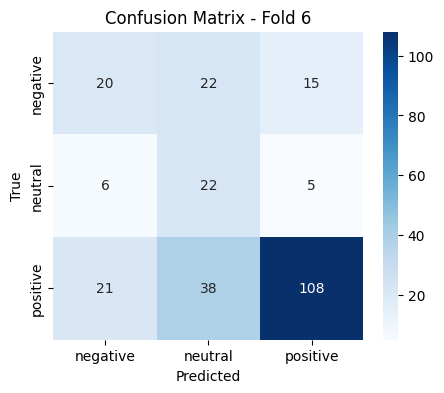


📦 Fold 7 Starting...
Epoch 1/20


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.4836 - loss: 1.0603 - val_accuracy: 0.5253 - val_loss: 0.9440
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5065 - loss: 0.9590 - val_accuracy: 0.3930 - val_loss: 1.0827
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5235 - loss: 0.9225 - val_accuracy: 0.4981 - val_loss: 0.9475
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6212 - loss: 0.8012 - val_accuracy: 0.4514 - val_loss: 1.0224
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
✅ Fold 7 Accuracy: 0.5253
🧮 Fold 7 Log Loss: 0.9440

📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.33      0.35      0.34        57
     neutral       0.25      0.61      0.35        33
    positive       0.82      0.57      0.67       167

    accuracy                           0.53       257
   macro avg       0.47      0.51      0.45       257
weighted avg       0.64      0.53      0.56       257



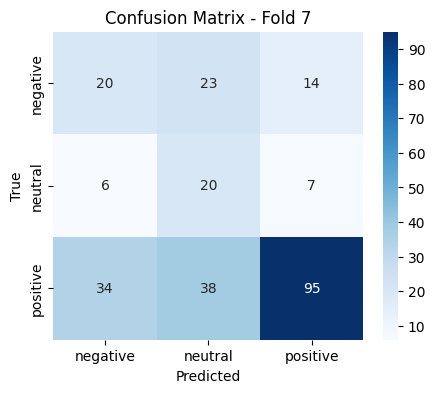


📦 Fold 8 Starting...
Epoch 1/20


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.4752 - loss: 1.0713 - val_accuracy: 0.4903 - val_loss: 0.9706
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4995 - loss: 0.9807 - val_accuracy: 0.4825 - val_loss: 1.0212
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5354 - loss: 0.9255 - val_accuracy: 0.4475 - val_loss: 1.1052
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5606 - loss: 0.8396 - val_accuracy: 0.5292 - val_loss: 0.9989
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
✅ Fold 8 Accuracy: 0.4903
🧮 Fold 8 Log Loss: 0.9706

📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.44      0.14      0.21        57
     neutral       0.18      0.61      0.28        33
    positive       0.76      0.59      0.66       167

    accuracy                           0.49       257
   macro avg       0.46      0.44      0.39       257
weighted avg       0.62      0.49      0.51       257



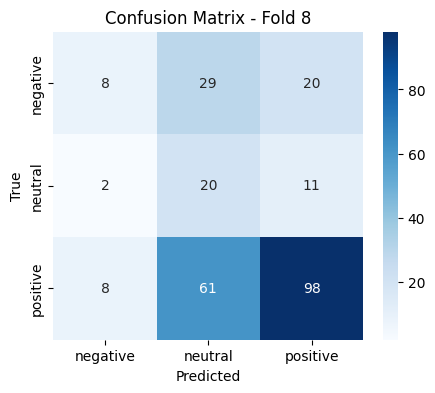


📦 Fold 9 Starting...
Epoch 1/20


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.4537 - loss: 1.0860 - val_accuracy: 0.3230 - val_loss: 1.1215
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4725 - loss: 0.9910 - val_accuracy: 0.3969 - val_loss: 1.0913
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5011 - loss: 0.9316 - val_accuracy: 0.3852 - val_loss: 1.1236
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5517 - loss: 0.8424 - val_accuracy: 0.5175 - val_loss: 0.9419
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6141 - loss: 0.7179 - val_accuracy: 0.5292 - val_loss: 0.9529
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6840 - loss: 0.6478 - val_accuracy: 0.5058 - val_loss: 1.0075
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7437 - loss: 0.5197 - val_accuracy: 0.5019 - val_loss: 1.0653
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
✅ Fold 9 Accuracy: 0.5175
🧮 Fold 9 Log Loss: 0.9419

📋 Classification Report:
      

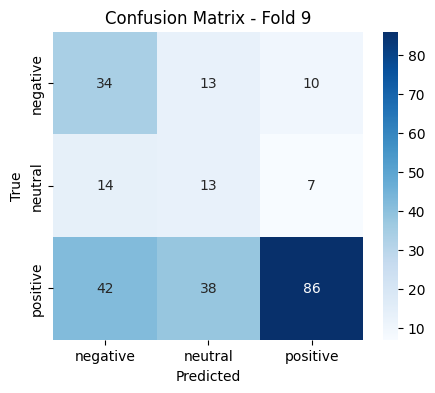


📦 Fold 10 Starting...


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.4231 - loss: 1.0771 - val_accuracy: 0.4436 - val_loss: 1.0531
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5244 - loss: 0.9704 - val_accuracy: 0.4397 - val_loss: 1.0064
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5460 - loss: 0.8955 - val_accuracy: 0.3541 - val_loss: 1.1350
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5789 - loss: 0.8004 - val_accuracy: 0.5253 - val_loss: 0.9888
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6419 - loss: 0.6846 - val_accuracy: 0.4397 - val_loss: 1.1029
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6984 - loss: 0.5929 - val_accuracy: 0.5136 - val_loss: 0.9969
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7280 - loss: 0.5266 - val_accuracy: 0.5058 - val_loss: 1.0250
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
✅ Fold 10 Accuracy: 0.5253
🧮 Fold 10 Log Loss: 0.9888

📋 Classification R

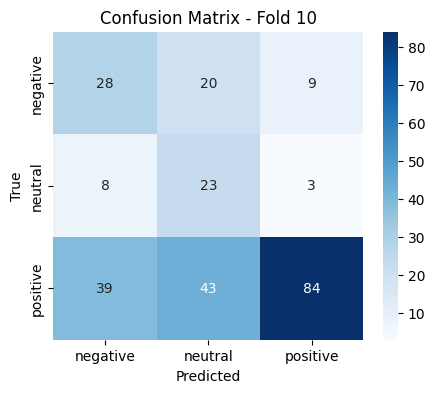


📊 Final Evaluation Summary:
        accuracy   log_loss
count  10.000000  10.000000
mean    0.526848   0.930523
std     0.034227   0.043006
min     0.490272   0.851218
25%     0.500000   0.904658
50%     0.521401   0.942922
75%     0.548638   0.951082
max     0.583658   0.988805


In [16]:
# EVALUATE MODEL
#================================
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])
y = to_categorical(df['label'].values, num_classes=3)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label']),
    y=df['label']
)
class_weights_dict = dict(enumerate(class_weights))

# K-Fold Setup
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_no = 1
metrics_summary = []

for train_idx, val_idx in kfold.split(padded_sequences, df['label']):
    print(f"\n📦 Fold {fold_no} Starting...")

    X_train, X_val = padded_sequences[train_idx], padded_sequences[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    y_val_labels = df['label'].values[val_idx]  # for classification report

    # Build model
    model = build_cnn_bilstm_model(
        vocab_size=len(tokenizer.word_index)+1,
        embedding_matrix=embedding_matrix,
        max_len=max_len,
        embedding_dim=100,
        num_classes=3
    )

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=[es],
        verbose=1
    )

    # Evaluation
    y_pred_probs = model.predict(X_val)
    y_pred = y_pred_probs.argmax(axis=1)

    acc = np.mean(y_pred == y_val_labels)
    logloss = log_loss(y_val_labels, y_pred_probs)

    print(f"✅ Fold {fold_no} Accuracy: {acc:.4f}")
    print(f"🧮 Fold {fold_no} Log Loss: {logloss:.4f}")
    print("\n📋 Classification Report:")
    print(classification_report(y_val_labels, y_pred, target_names=label_encoder.classes_))

    # Save metrics summary
    metrics_summary.append({
        'fold': fold_no,
        'accuracy': acc,
        'log_loss': logloss
    })

    # Confusion Matrix
    cm = confusion_matrix(y_val_labels, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - Fold {fold_no}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    fold_no += 1

# === Final Summary ===
df_metrics = pd.DataFrame(metrics_summary)
print("\n📊 Final Evaluation Summary:")
print(df_metrics.describe()[['accuracy', 'log_loss']])
